In [4]:
# import required modules
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler

# note- run in 'base' environment

In [5]:
# read data 
cat_data_original = pd.read_csv('/Users/IsabelSmokelin/Desktop/Harvard/F23/9.660/Project/feline_foraging/cat_clean.csv')

In [6]:
# subest data to placement and subject
cat_data = cat_data_original.iloc[:, 0:3]
cat_data

,Subject,treat_placement,Time_to_treat_s
0,1,1,4.71
1,1,1,4.47
2,1,1,4.26
3,1,1,2.99
4,1,1,3.91
5,1,2,19.21
6,1,2,10.10
7,1,2,8.78
8,1,2,5.08
9,1,2,3.85


In [7]:
# pull out time to treat
numerical_columns = ['Time_to_treat_s']
numerical_data = cat_data[numerical_columns]

# normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# make new df w/ scaled data
normalized_cat_data = pd.DataFrame(normalized_data, columns=numerical_columns)
cat_data_normalized = pd.concat([normalized_cat_data, cat_data.drop(columns=numerical_columns)], axis=1)
cat_data_normalized

,Time_to_treat_s,Subject,treat_placement
0,-0.815660,1,1
1,-0.851526,1,1
2,-0.882909,1,1
3,-1.072702,1,1
4,-0.935214,1,1
5,1.351263,1,2
6,-0.010162,1,2
7,-0.207427,1,2
8,-0.760366,1,2
9,-0.944181,1,2


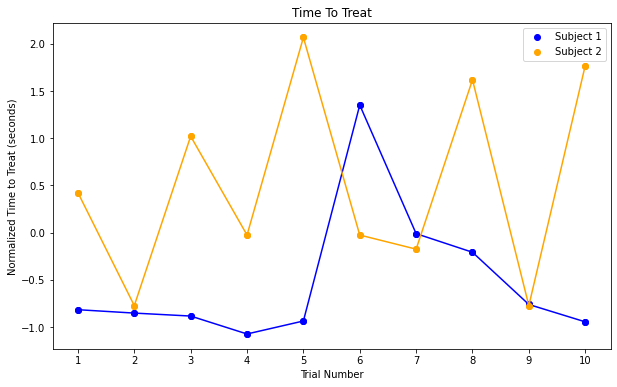

In [8]:
# Separate cat_data for S1 and S2
cat_data = cat_data_normalized # reassign cat data to normlaized
cat_data_s1 = cat_data[cat_data['Subject'] == 1]
cat_data_s2 = cat_data[cat_data['Subject'] == 2]

# Plot raw cat_data
plt.figure(figsize=(10, 6))

plt.scatter(range(1, len(cat_data_s1) + 1), cat_data_s1['Time_to_treat_s'], label='Subject 1', color='blue')
plt.plot(range(1, len(cat_data_s1) + 1), cat_data_s1['Time_to_treat_s'], color='blue', linestyle='-', marker='o')

plt.scatter(range(1, len(cat_data_s2) + 1), cat_data_s2['Time_to_treat_s'], label='Subject 2', color='orange')
plt.plot(range(1, len(cat_data_s2) + 1), cat_data_s2['Time_to_treat_s'], color='orange', linestyle='-', marker='o')

plt.title('Time To Treat')
plt.xlabel('Trial Number')
plt.xticks(range(1, 11))
plt.ylabel('Normalized Time to Treat (seconds)')
plt.legend()
plt.show()

## Non-hierarchical Model 1 (placement effect)

/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [placement_effect, sigma, mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/arviz/dat

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu                  -0.180  2.881  -5.857    5.052      0.123    0.096   
placement_effect[0]  0.010  2.885  -5.681    5.215      0.122    0.093   
placement_effect[1]  0.354  2.883  -5.335    5.655      0.123    0.097   
sigma                1.127  0.201   0.837    1.529      0.008    0.006   

                     ess_bulk  ess_tail  r_hat  
mu                      564.0     446.0    1.0  
placement_effect[0]     569.0     457.0    1.0  
placement_effect[1]     559.0     450.0    1.0  
sigma                   358.0     199.0    1.0  


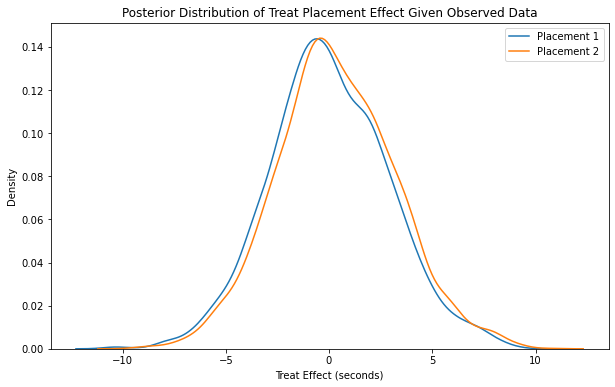

In [9]:
# initiate model
with pm.Model() as cat_model:

    # Prior distributions for mean time to treat given factors
    mu = pm.Normal('mu', mu = cat_data['Time_to_treat_s'].mean(), sd=5)
    sigma = pm.HalfNormal('sigma', sd=5)
    
    # effect of treat placement
    placement_effect = pm.Normal('placement_effect', mu=0, sd=5, shape=len(cat_data['treat_placement'].unique()))
    
    # likelihood of data, given treat placement
    likelihood = pm.Normal('likelihood', mu=mu + placement_effect[cat_data['treat_placement'] - 1], sd=sigma, observed=cat_data['Time_to_treat_s'])

# MCMC sampling
with cat_model:
    trace = pm.sample(2000, tune=1000, chains=2, random_seed = 17)

# viz results
print(pm.summary(trace))


# pull out posterior samples of treat_effect
placement_effect_samples = trace['placement_effect']

# viz
plt.figure(figsize=(10, 6))
sns.kdeplot(placement_effect_samples[:, 0], label='Placement 1')
sns.kdeplot(placement_effect_samples[:, 1], label='Placement 2')

plt.title('Posterior Distribution of Treat Placement Effect Given Observed Data')
plt.xlabel('Treat Effect (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Non-hierarchical Model 1 (subject effect)

/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Subject, sigma, mu]


/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         -0.184  2.799  -5.566    4.778      0.113    0.080     611.0   
Subject[0] -0.335  2.801  -5.378    4.998      0.112    0.079     625.0   
Subject[1]  0.699  2.801  -4.438    5.926      0.113    0.080     609.0   
sigma       0.982  0.175   0.722    1.318      0.007    0.005     630.0   

            ess_tail  r_hat  
mu             895.0    1.0  
Subject[0]    1005.0    1.0  
Subject[1]     956.0    1.0  
sigma          504.0    1.0  


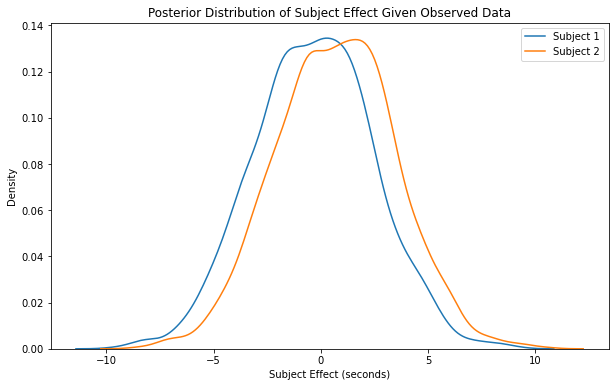

In [10]:
# establish the cat model
with pm.Model() as cat_model:

    # Prior distributions for mean time to treat given factors
    mu = pm.Normal('mu', mu = cat_data['Time_to_treat_s'].mean(), sd=5)
    sigma = pm.HalfNormal('sigma', sd=5)
    
    # effect of subject
    subject_effect = pm.Normal('Subject', mu=0, sd=5, shape=len(cat_data['Subject'].unique()))
    
    # likelihood of data, given subject
    likelihood = pm.Normal('likelihood', mu=mu + subject_effect[cat_data['Subject'] - 1], sd=sigma, observed=cat_data['Time_to_treat_s'])

# MCMC sampling
with cat_model:
    trace = pm.sample(2000, tune=1000, chains=2, random_seed = 17)

# viz results
print(pm.summary(trace))


# get posterior samples of subj_effect
treat_effect_samples = trace['Subject']

# viz
plt.figure(figsize=(10, 6))
sns.kdeplot(treat_effect_samples[:, 0], label='Subject 1')
sns.kdeplot(treat_effect_samples[:, 1], label='Subject 2')

plt.title('Posterior Distribution of Subject Effect Given Observed Data')
plt.xlabel('Subject Effect (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Hierarchical Bayes model

/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [subject_effect, sigma_pop, mu_pop]
>CategoricalGibbsMetropolis: [path_effect]
>BinaryGibbsMetropolis: [distract_effect, placement_effect]


/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/IsabelSmokelin/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_pop                8.963  3.093   3.115   14.601      0.065    0.046   
subject_effect[0]    -3.620  3.211  -9.368    2.527      0.061    0.043   
subject_effect[1]     2.505  3.208  -3.384    8.590      0.064    0.046   
path_effect[0]        1.329  0.764   0.000    2.000      0.009    0.006   
path_effect[1]        0.663  0.760   0.000    2.000      0.009    0.006   
path_effect[2]        0.999  0.818   0.000    2.000      0.005    0.004   
distract_effect[0]    0.298  0.457   0.000    1.000      0.005    0.003   
distract_effect[1]    0.689  0.463   0.000    1.000      0.005    0.003   
placement_effect[0]   0.398  0.490   0.000    1.000      0.004    0.003   
placement_effect[1]   0.592  0.492   0.000    1.000      0.004    0.003   
sigma_pop             5.988  1.031   4.279    7.961      0.018    0.013   
combo_effect[0]       6.702  2.009   2.963   10.645      0.023    0.016   
combo_effect[1]       7.3

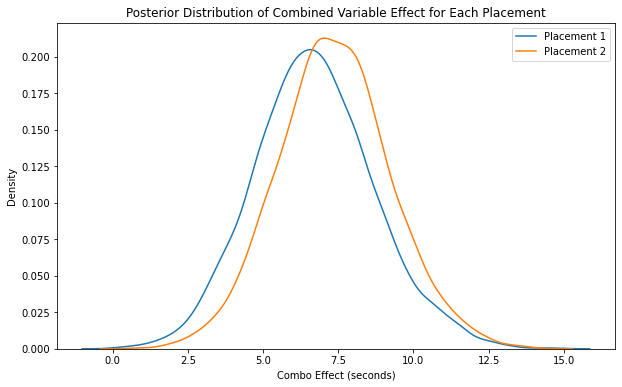

In [11]:
# Model with hierarchical structure

# add back in the other variables (distractedness, path)
cat_data2 = cat_data_original

with pm.Model() as cat_model:

    # Prior distributions based on factors
    mu_pop = pm.Normal('mu_pop', mu=cat_data2['Time_to_treat_s'].mean(), sd=5)
    sigma_pop = pm.HalfNormal('sigma_pop', sd=5)
    
    # Effect = subject
    subject_effect = pm.Normal('subject_effect', mu=0, sd=5, shape=len(cat_data2['Subject'].unique()))
    
    # Effect  = path to food
    path_effect = pm.Categorical('path_effect', p=[0.33, 0.33, 0.34], shape=len(cat_data2['Path_to_food'].unique()))

    # Effect = Distractability
    distract_effect = pm.Bernoulli('distract_effect', p=0.5, shape=len(cat_data2['Distractability'].unique()))

    # Effect = Placement
    placement_effect = pm.Bernoulli('placement_effect', p=0.5, shape=len(cat_data2['treat_placement'].unique()))

    # Combine effects
    combo_effect = pm.Deterministic('combo_effect', mu_pop + subject_effect[cat_data2['Subject'].values - 1] +
                                    path_effect[cat_data2['Path_to_food'].astype(int).values] +
                                    distract_effect[cat_data2['Distractability'].values] +
                                    placement_effect[cat_data2['treat_placement'].values - 1])

    # Likelihood of data given factors
    likelihood = pm.Normal('likelihood', mu=combo_effect, sd=sigma_pop, observed=cat_data2['Time_to_treat_s'])

# Adjust priors to match actual data sd
cat_model['mu_pop'].distribution = pm.Normal.dist(mu=cat_data2['Time_to_treat_s'].mean(), sd=6.53)
cat_model['sigma_pop'].distribution = pm.HalfNormal.dist(sd=6.53) 

# MCMC sampling
with cat_model:
    trace = pm.sample(4000, tune=2000, chains=2, random_seed=17)

# summaize results
print(pm.summary(trace))

# get posterior samples of combo_effect
combo_effect_samples = trace['combo_effect']

# viz
plt.figure(figsize=(10, 6))
sns.kdeplot(combo_effect_samples[:, 0], label='Placement 1')
sns.kdeplot(combo_effect_samples[:, 1], label='Placement 2')

plt.title('Posterior Distribution of Combined Variable Effect for Each Placement')
plt.xlabel('Combo Effect (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()
